In [29]:
import random
import json
import pickle
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

In [30]:
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Morsi Store
[nltk_data]     DZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Morsi Store
[nltk_data]     DZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Morsi Store
[nltk_data]     DZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

train_data = load_data('train_light.json')
dev_data = load_data('dev_light.json')

In [32]:
def preprocess_data(data):
    rows = []
    for item in data:
        question = item["question"]
        annotations = item["annotations"]
        for annotation in annotations:
            if annotation["type"] == "multipleQAs":
                for qa in annotation["qaPairs"]:
                    rows.append({
                        "id": item["id"],
                        "question": qa["question"],
                        "answer": qa["answer"][0],
                        "type": annotation["type"]
                    })
            elif annotation["type"] == "singleAnswer":
                rows.append({
                    "id": item["id"],
                    "question": question,
                    "answer": annotation["answer"][0],
                    "type": annotation["type"]
                })
    return pd.DataFrame(rows)


In [33]:

train_light_df = preprocess_data(train_data)
dev_light_df = preprocess_data(dev_data)
train_light_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19541 entries, 0 to 19540
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19541 non-null  object
 1   question  19541 non-null  object
 2   answer    19541 non-null  object
 3   type      19541 non-null  object
dtypes: object(4)
memory usage: 610.8+ KB


In [34]:
# Count the number of each type
type_counts = train_light_df['type'].value_counts()
print(type_counts)


type
multipleQAs     14082
singleAnswer     5459
Name: count, dtype: int64


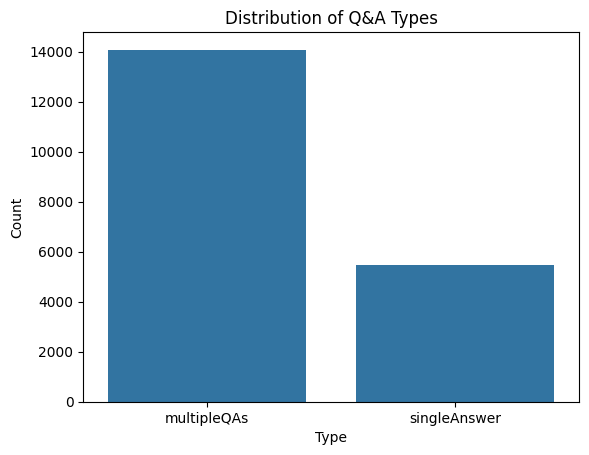

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=type_counts.index, y=type_counts.values)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Q&A Types')
plt.show()


In [36]:
train_light_df.columns

Index(['id', 'question', 'answer', 'type'], dtype='object')

In [37]:
import torch
print(torch.__version__)


2.3.1+cpu


In [38]:
from transformers import BertTokenizer, BertForQuestionAnswering

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
from torch.utils.data import Dataset

class QADataset(Dataset):
    def __init__(self, questions,answers, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self,item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
    
        encoding = self.tokenizer(
            question,
            answer, 
            add_special_tokens=True, 
            max_length=self.max_len, 
            return_token_type_ids=True,
            truncation = 'only_first',
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            return_overflowing_tokens=True
        )

        start_pos = 0
        end_pos = len(answer) - 1


        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        token_type_ids = encoding['token_type_ids'].flatten()

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'start_positions': torch.tensor(start_pos, dtype=torch.long),
            'end_positions': torch.tensor(end_pos, dtype=torch.long)
        }

In [40]:
questions = train_light_df['question'].to_list()
answers = train_light_df['answer'].to_list()
dataset = QADataset(questions, answers, tokenizer, max_len=64)

from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=2)

In [41]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: False
Number of GPUs: 0
GPU name: No GPU detected


In [42]:
from transformers import BertForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
import torch

optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(dataloader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

model.to(device)
model.train()
for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_positions,
            end_positions=end_positions
        )
        
        loss = outputs.loss
        if torch.is_tensor(loss):
            loss.backward()
            optimizer.step()
            scheduler.step()
    
    print(f"Epoch {epoch} Loss: {loss.item()}")


Using device: cpu


c:\Users\Morsi Store DZ\ai-vol-2\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We need to remove 18 to truncate the input but the first sequence has a length 9. Please select another truncation strategy than TruncationStrategy.ONLY_FIRST, for instance 'longest_first' or 'only_second'.


RuntimeError: stack expects each tensor to be equal size, but got [82] at entry 0 and [64] at entry 1